In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
"""from keras.models import Sequential
from keras.layers import Dense"""

from tensorflow.python.keras.layers import Input, Dense
from tensorflow.python.keras.models import Sequential

import matplotlib.patches as mpatches
from keras.layers import Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, accuracy_score
import tensorflow as tf
from tensorflow.keras.metrics import Accuracy
import keras as K
from keras.layers import Dense,RepeatVector
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils.vis_utils import plot_model
import os
import glob

In [ ]:
REL_FEATURES = [' _dewptm', ' _fog', ' _hail', ' _hum', ' _pressurem', ' _rain', ' _snow',
                ' _thunder', ' _tornado', ' _vism', ' _wspdm', 'night', 'morning',
                'noon', 'evening', 'month_cos', 'month_sin', 'hour_cos', 'hour_sin', 'week_cos', 'week_sin']
LABEL = ['Temp']

# Time Series Forecast using LSTM

In [ ]:
def df_train_test(model_name):
    df_train = pd.read_csv(f'df_{model_name}_train.csv')
    df_test = pd.read_csv(f'df_{model_name}_test.csv')
    return df_train, df_test

In [ ]:
def custom_accuracy_mse(y_true, y_pred):
    true = []
    pred = []
    true.append(y_true[0][:-2])
    pred.append(y_pred[0][:-2])

    for t, p in zip(y_true, y_pred):
        true.append(t[2:])
        pred.append(p[2:])

    true = np.array(true).ravel()
    pred = np.array(pred).ravel()

    mse_train = mean_squared_error(true, pred)
    acc_train = accuracy_score(true, pred)

    return acc_train, mse_train

In [ ]:
def main_func(model_name='', rel_features_train=REL_FEATURES, 
              rel_features_test=REL_FEATURES, label=LABEL, 
              timestep=28, df_train=False, df_test=False, 
              epochs=500):
    try:
        if not df_train:
            df_train, df_test = df_train_test(model_name)
    except:
        pass

    df_train.set_index('datetime', inplace= True)
    df_test.set_index('datetime', inplace= True)

    X_train = df_train[rel_features_train].values.astype('float32')
    X_test = df_test[rel_features_test].values.astype('float32')

    Y_train = df_train[label].values.astype('float32')
    Y_test = df_test[label].values.astype('float32')

    for j, df in enumerate([[X_train, Y_train], [X_test, Y_test]]):
        x, y = df
        X = []
        Y = []
        
        for i in range(int(len(x)/(timestep))):
            if i == 0:
                X.append(x[i * timestep : i * timestep + timestep + 2])
                Y.append(y[i * timestep : i * timestep + timestep + 2])
            else:
                X.append(x[i * timestep - 2 : i * timestep + timestep])
                Y.append(y[i * timestep - 2 : i * timestep + timestep])

        X = np.asanyarray(X)
        Y = np.asanyarray(Y)
        
        if j == 0:
            X_train = X
            Y_train = Y
        else:
            X_test = X
            Y_test = Y
    
    #the model
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, activation='relu', input_shape=(timestep + 2, len(rel_features_train))))
    model.add(Dense(1))
    model.compile(loss=['mse'], optimizer='adam', metrics=['accuracy'])
    #model.compile(loss=[loss], optimizer='adam', metrics=['accuracy'])
    history = model.fit(X_train,Y_train, epochs=epochs, verbose=0, validation_data=(X_test, Y_test) )

    preds_train = np.round(model.predict(X_train))
    preds_test = np.round(model.predict(X_test))

    acc_train, mse_train = custom_accuracy_mse(Y_train, preds_train)
    acc_test, mse_test = custom_accuracy_mse(Y_test, preds_test)

    """mse_train = mean_squared_error(Y_train.ravel(), preds_train.ravel())
    mse_test = mean_squared_error(Y_test.ravel(), preds_test.ravel())

    acc_train = accuracy_score(Y_train.ravel(), preds_train.ravel())
    acc_test = accuracy_score(Y_test.ravel(), preds_test.ravel())"""

    print(f'MSE train: {mse_train}')
    print(f'MSE test: {mse_test}')

    print(f'Accuracy train: {acc_train}')
    print(f'Accuracy test: {acc_test}')

    """plt.figure(figsize=(25,10))
    plt.plot(Y_test.ravel(), 'blue', linewidth=0.1)
    plt.plot(preds_test.ravel(),'r' , linewidth=0.1)
    plt.legend(('Test','Predicted'))
    plt.show()"""

    try:
        # summarize history for loss
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title(f'model {model_name} loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.savefig(f'{model_name}_loss.png')
        plt.close()
    except:
        pass

    return mse_train, mse_test, acc_train, acc_test

    """# summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()"""

# **CNN-LSTM Model**
## train on x **first** years only

In [ ]:
data = {}

for day_part in ['night', 'morning', 'noon', 'evening']:
    freq_part = 'full'
    model_name = '_'.join([freq_part, day_part])
    print(model_name)

    df_train = pd.read_csv(f'df_{model_name}_train.csv')
    df_test = pd.read_csv(f'df_{model_name}_test.csv')
    mse_train, mse_test, acc_train, acc_test = main_func(df_train=df_train, df_test=df_test, timestep=7)
    data[f'10_{model_name}'] = [mse_train, mse_test, acc_train, acc_test]

    for year in range(2, 10, 2):
        df_train = pd.read_csv(f'df_{year}_{model_name}_train.csv')
        df_test = pd.read_csv(f'df_{model_name}_test.csv')
        mse_train, mse_test, acc_train, acc_test = main_func(df_train=df_train, df_test=df_test, timestep=7)
        data[f'{year}_{model_name}'] = [mse_train, mse_test, acc_train, acc_test]
    


df = pd.DataFrame.from_dict(data, orient='index', columns=['mse_train', 'mse_test', 'acc_train', 'acc_test'])
df.to_csv(r'results.csv', index = True)

full_night
MSE train: 0.1363249123096466
MSE test: 0.27223721146583557
Accuracy train: 0.8645271229764272
Accuracy test: 0.7439353099730458
MSE train: 0.22704081237316132
MSE test: 0.7654986381530762
Accuracy train: 0.7729591836734694
Accuracy test: 0.40431266846361186
MSE train: 0.1953352838754654
MSE test: 1.0188679695129395
Accuracy train: 0.8046647230320699
Accuracy test: 0.4339622641509434
MSE train: 0.1785714328289032
MSE test: 0.2857142984867096
Accuracy train: 0.8214285714285714
Accuracy test: 0.7223719676549866
MSE train: 0.14369256794452667
MSE test: 0.26954177021980286
Accuracy train: 0.8579782790309106
Accuracy test: 0.7466307277628033
full_morning
MSE train: 0.2050185352563858
MSE test: 0.37637361884117126
Accuracy train: 0.7958368976333048
Accuracy test: 0.6318681318681318
MSE train: 0.22448979318141937
MSE test: 0.8049450516700745
Accuracy train: 0.7793367346938775
Accuracy test: 0.47802197802197804
MSE train: 0.2215743511915207
MSE test: 0.6236263513565063
Accuracy trai

In [ ]:
df

,mse_train,mse_test,acc_train,acc_test
10_full_night,0.136325,0.272237,0.864527,0.743935
2_full_night,0.227041,0.765499,0.772959,0.404313
4_full_night,0.195335,1.018868,0.804665,0.433962
6_full_night,0.178571,0.285714,0.821429,0.722372
8_full_night,0.143693,0.269542,0.857978,0.746631
10_full_morning,0.205019,0.376374,0.795837,0.631868
2_full_morning,0.224490,0.804945,0.779337,0.478022
4_full_morning,0.221574,0.623626,0.778426,0.467033
6_full_morning,0.220128,0.458791,0.783264,0.574176
8_full_morning,0.232422,0.335165,0.775949,0.681319


## Analyze results

In [ ]:

#df = pd.read_csv(r'res/results.csv', index_col=0)
# df['freq'] = ''
# df['day_part'] = ''

for model_name, model_row in df.iterrows():
#     print('\t', (model_name))

    if 'full' in str(model_name):
#         print('full_year')
        df.loc[model_name, 'freq'] = 'full_year'
    elif any(season in str(model_name) for season in ['winter', 'spring', 'summer', 'monsoon', 'autumn']):
#         print('season')
        df.loc[model_name, 'freq'] = 'season'
    elif any(str(month) in str(model_name) for month in range(1,13)):
#         print('month')
        df.loc[model_name, 'freq'] = 'month'
    else:
        raise 'error'
    if 'all' in str(model_name):
#         print('all_day')
        df.loc[model_name, 'day_part'] = 'all_day'
    elif any(season in str(model_name) for season in ['night', 'morning', 'noon', 'evening']):
#         print('day_part')
        df.loc[model_name, 'day_part'] = 'one_part'
    else:
        raise 'error'
    for year in range(2, 11, 2):
        if str(year) in str(model_name):
            df.loc[model_name, 'year'] = year

df

,mse_train,mse_test,acc_train,acc_test,freq,day_part,year
10_full_night,0.136325,0.272237,0.864527,0.743935,full_year,one_part,10.0
2_full_night,0.227041,0.765499,0.772959,0.404313,full_year,one_part,2.0
4_full_night,0.195335,1.018868,0.804665,0.433962,full_year,one_part,4.0
6_full_night,0.178571,0.285714,0.821429,0.722372,full_year,one_part,6.0
8_full_night,0.143693,0.269542,0.857978,0.746631,full_year,one_part,8.0
10_full_morning,0.205019,0.376374,0.795837,0.631868,full_year,one_part,10.0
2_full_morning,0.224490,0.804945,0.779337,0.478022,full_year,one_part,2.0
4_full_morning,0.221574,0.623626,0.778426,0.467033,full_year,one_part,4.0
6_full_morning,0.220128,0.458791,0.783264,0.574176,full_year,one_part,6.0
8_full_morning,0.232422,0.335165,0.775949,0.681319,full_year,one_part,8.0


In [ ]:
df.groupby(['freq', 'day_part', 'year'])[['mse_test', 'acc_test', 'mse_train', 'acc_train']].mean()

mse_test  acc_test  mse_train  acc_train
freq      day_part year                                          
full_year one_part 2.0   0.710242  0.489787   0.213648   0.788265
                   4.0   0.747930  0.472421   0.185423   0.815015
                   6.0   0.338505  0.678021   0.163942   0.836906
                   8.0   0.285442  0.728903   0.154622   0.847888
                   10.0  0.294358  0.715907   0.151527   0.848900

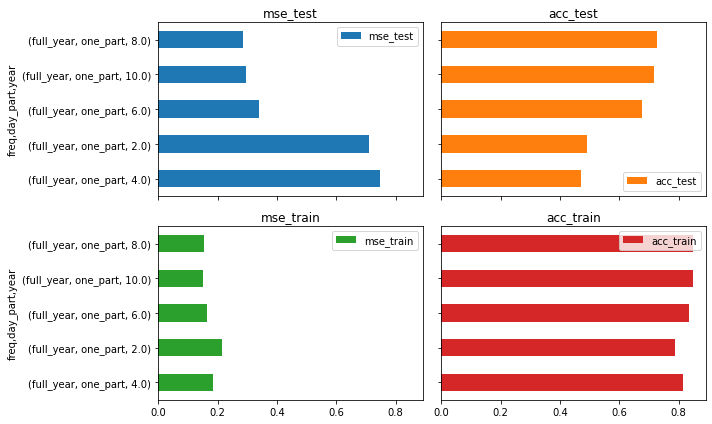

In [ ]:
df.groupby(['freq', 'day_part', 'year'])[['mse_test', 'acc_test', 'mse_train', 'acc_train']].mean()\
  .sort_values('mse_test', ascending=False)\
  .plot.barh(y=['mse_test', 'acc_test', 'mse_train', 'acc_train'], 
              subplots=True, layout=(2, 2), sharey=True, figsize=(10, 6))
plt.tight_layout()
plt.savefig('model_cmp.png')

# **CNN-LSTM Model**
## train on x **first** years and 10-x predicted by HMM

In [ ]:
data = {}

for year in range(2, 10, 2):

    for day_part in ['night', 'morning', 'noon', 'evening']:
        li = []
        for month in range(1, 13):
            filename = f'CP_{year}df_{month}_{day_part}_train.csv'
            dff = pd.read_csv(filename, index_col=None, header=0)
            li.append(dff)
        df_train = pd.concat(li, axis=0, ignore_index=True)
        df_train = df_train.sort_values(['year', 'month', 'week', 'day', 'night', 'morning', 'noon', 'evening'], ascending=[True]*4 + [False]*4).reset_index(drop=True)

        freq_part = 'full'
        model_name = '_'.join([freq_part, day_part])
        print(model_name)

        df_test = pd.read_csv(f'df_{model_name}_test.csv')

        REL_FEATURES_TRAIN = [' _dewptm_bars', ' _fog', ' _hail', ' _hum_bars', ' _pressurem_bars', ' _rain', ' _snow',
                ' _thunder', ' _tornado', ' _vism_bars', ' _wspdm_bars', 'night', 'morning',
                'noon', 'evening', 'month_cos', 'month_sin', 'week_cos', 'week_sin']
                
        REL_FEATURES_TEST = [ele for ele in REL_FEATURES if ele not in ['hour_sin', 'hour_cos']]

        mse_train, mse_test, acc_train, acc_test = main_func(df_train=df_train, df_test=df_test, timestep=7, 
                                                             rel_features_train=REL_FEATURES_TRAIN, 
                                                             rel_features_test=REL_FEATURES_TEST, 
                                                             epochs=500)
        data[f'{year}_{model_name}'] = [mse_train, mse_test, acc_train, acc_test]

"""df_train = pd.read_csv(f'df_{model_name}_train.csv')
df_test = pd.read_csv(f'df_{model_name}_test.csv')
mse_train, mse_test, acc_train, acc_test = main_func(df_train=df_train, df_test=df_test, timestep=7)
data[f'10_{model_name}'] = [mse_train, mse_test, acc_train, acc_test]"""

df = pd.DataFrame.from_dict(data, orient='index', columns=['mse_train', 'mse_test', 'acc_train', 'acc_test'])
df.to_csv(r'results_hmm.csv', index = True)

full_night
MSE train: 0.02443901263177395
MSE test: 3.878706216812134
Accuracy train: 0.9762275049988891
Accuracy test: 0.20485175202156333
full_morning
MSE train: 0.017829284071922302
MSE test: 22.83241844177246
Accuracy train: 0.9821707154000445
Accuracy test: 0.038461538461538464
full_noon
MSE train: 0.0049030533991754055
MSE test: 16.093406677246094
Accuracy train: 0.9950969467350123
Accuracy test: 0.04120879120879121
full_evening
MSE train: 0.007389162667095661
MSE test: 12.375349998474121
Accuracy train: 0.9926108374384236
Accuracy test: 0.13445378151260504
full_night
MSE train: 0.008442568592727184
MSE test: 3.5175201892852783
Accuracy train: 0.9915574316818485
Accuracy test: 0.14285714285714285
full_morning
MSE train: 0.016269221901893616
MSE test: 11.329669952392578
Accuracy train: 0.9837307778025407
Accuracy test: 0.07417582417582418
full_noon
MSE train: 0.005794517695903778
MSE test: 16.019229888916016
Accuracy train: 0.9942054825050145
Accuracy test: 0.08241758241758242
ful

In [ ]:
df

,mse_train,mse_test,acc_train,acc_test
2_full_night,0.019329,18.482479,0.981337,0.086253
2_full_morning,0.020949,17.313187,0.979051,0.038462
2_full_noon,0.016046,11.923077,0.983954,0.104396
2_full_evening,0.005150,6.929972,0.994850,0.148459
4_full_night,0.019996,3.134771,0.980671,0.150943
4_full_morning,0.021841,10.343407,0.978159,0.076923
4_full_noon,0.012480,6.442307,0.987520,0.126374
4_full_evening,0.008509,3.207283,0.991491,0.243697
6_full_night,0.004443,6.307278,0.995557,0.226415
6_full_morning,0.018721,21.219780,0.981279,0.024725


## Analyze results

In [ ]:

#df = pd.read_csv(r'res/results.csv', index_col=0)
# df['freq'] = ''
# df['day_part'] = ''

for model_name, model_row in df.iterrows():
#     print('\t', (model_name))

    if 'full' in str(model_name):
#         print('full_year')
        df.loc[model_name, 'freq'] = 'full_year'
    elif any(season in str(model_name) for season in ['winter', 'spring', 'summer', 'monsoon', 'autumn']):
#         print('season')
        df.loc[model_name, 'freq'] = 'season'
    elif any(str(month) in str(model_name) for month in range(1,13)):
#         print('month')
        df.loc[model_name, 'freq'] = 'month'
    else:
        raise 'error'
    if 'all' in str(model_name):
#         print('all_day')
        df.loc[model_name, 'day_part'] = 'all_day'
    elif any(season in str(model_name) for season in ['night', 'morning', 'noon', 'evening']):
#         print('day_part')
        df.loc[model_name, 'day_part'] = 'one_part'
    else:
        raise 'error'
    for year in range(2, 11, 2):
        if str(year) in str(model_name):
            df.loc[model_name, 'year'] = year

df

,mse_train,mse_test,acc_train,acc_test,freq,day_part,year
2_full_night,0.019329,18.482479,0.981337,0.086253,full_year,one_part,2.0
2_full_morning,0.020949,17.313187,0.979051,0.038462,full_year,one_part,2.0
2_full_noon,0.016046,11.923077,0.983954,0.104396,full_year,one_part,2.0
2_full_evening,0.005150,6.929972,0.994850,0.148459,full_year,one_part,2.0
4_full_night,0.019996,3.134771,0.980671,0.150943,full_year,one_part,4.0
4_full_morning,0.021841,10.343407,0.978159,0.076923,full_year,one_part,4.0
4_full_noon,0.012480,6.442307,0.987520,0.126374,full_year,one_part,4.0
4_full_evening,0.008509,3.207283,0.991491,0.243697,full_year,one_part,4.0
6_full_night,0.004443,6.307278,0.995557,0.226415,full_year,one_part,6.0
6_full_morning,0.018721,21.219780,0.981279,0.024725,full_year,one_part,6.0


In [ ]:
df.groupby(['freq', 'day_part', 'year'])[['mse_test', 'acc_test', 'mse_train', 'acc_train']].mean()

mse_test  acc_test  mse_train  acc_train
freq      day_part year                                           
full_year one_part 2.0   13.662179  0.094392   0.015369   0.984798
                   4.0    5.781942  0.149484   0.015706   0.984460
                   6.0   10.551650  0.120881   0.011550   0.988450
                   8.0    6.533410  0.131620   0.010011   0.989989

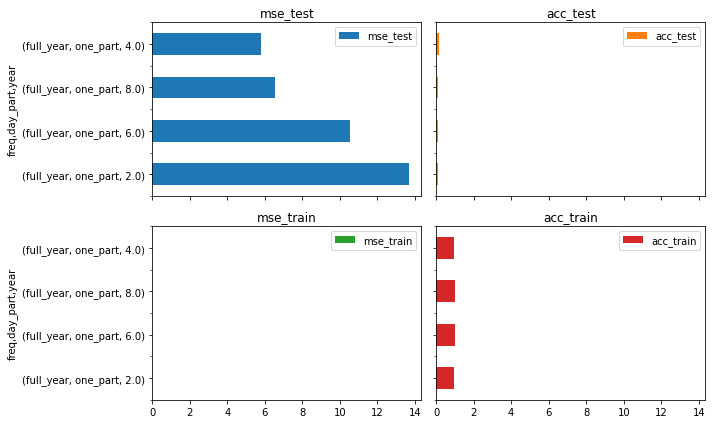

In [ ]:
df.groupby(['freq', 'day_part', 'year'])[['mse_test', 'acc_test', 'mse_train', 'acc_train']].mean()\
  .sort_values('mse_test', ascending=False)\
  .plot.barh(y=['mse_test', 'acc_test', 'mse_train', 'acc_train'], 
              subplots=True, layout=(2, 2), sharey=True, figsize=(10, 6))
plt.tight_layout()
plt.savefig('model_cmp.png')

# **CNN-LSTM Model**
## train on x **last** years only

In [ ]:
data = {}

freq_part = 'full'
for year in range(2, 10, 2):

    for day_part in ['night', 'morning', 'noon', 'evening']:
        model_name = '_'.join([freq_part, day_part])
        print(model_name)

        df_train = pd.read_csv(f'df_{year}_{model_name}_train.csv')
        df_test = pd.read_csv(f'df_{model_name}_test.csv')
        mse_train, mse_test, acc_train, acc_test = main_func(df_train=df_train, 
                                                             df_test=df_test, timestep=7, 
                                                             epochs=500)
        data[f'{year}_{model_name}'] = [mse_train, mse_test, acc_train, acc_test]


df = pd.DataFrame.from_dict(data, orient='index', columns=['mse_train', 'mse_test', 'acc_train', 'acc_test'])
df.to_csv(r'results.csv', index = True)

full_night
MSE train: 0.1687074899673462
MSE test: 0.4393531084060669
Accuracy train: 0.8312925170068027
Accuracy test: 0.6172506738544474
full_morning
MSE train: 0.24353741109371185
MSE test: 0.5384615659713745
Accuracy train: 0.7605442176870748
Accuracy test: 0.5521978021978022
full_noon
MSE train: 0.22176870703697205
MSE test: 0.450549453496933
Accuracy train: 0.7863945578231293
Accuracy test: 0.6071428571428571
full_evening
MSE train: 0.23023578524589539
MSE test: 0.4789915978908539
Accuracy train: 0.7697642163661581
Accuracy test: 0.6302521008403361
full_night
MSE train: 0.11209842562675476
MSE test: 0.3099730312824249
Accuracy train: 0.8879015721120984
Accuracy test: 0.7142857142857143
full_morning
MSE train: 0.19958987832069397
MSE test: 0.299450546503067
Accuracy train: 0.8004101161995899
Accuracy test: 0.7087912087912088
full_noon
MSE train: 0.1640464812517166
MSE test: 0.37637361884117126
Accuracy train: 0.8359535201640464
Accuracy test: 0.6648351648351648
full_evening
MSE tr

In [ ]:
df

,mse_train,mse_test,acc_train,acc_test
2_full_night,0.168707,0.439353,0.831293,0.617251
2_full_morning,0.243537,0.538462,0.760544,0.552198
2_full_noon,0.221769,0.450549,0.786395,0.607143
2_full_evening,0.230236,0.478992,0.769764,0.630252
4_full_night,0.112098,0.309973,0.887902,0.714286
4_full_morning,0.199590,0.299451,0.800410,0.708791
4_full_noon,0.164046,0.376374,0.835954,0.664835
4_full_evening,0.118585,0.316527,0.883495,0.708683
6_full_night,0.120493,0.377358,0.879507,0.692722
6_full_morning,0.209950,0.335165,0.795527,0.697802


## Analyze results

In [ ]:

#df = pd.read_csv(r'res/results.csv', index_col=0)
# df['freq'] = ''
# df['day_part'] = ''

for model_name, model_row in df.iterrows():
#     print('\t', (model_name))

    if 'full' in str(model_name):
#         print('full_year')
        df.loc[model_name, 'freq'] = 'full_year'
    elif any(season in str(model_name) for season in ['winter', 'spring', 'summer', 'monsoon', 'autumn']):
#         print('season')
        df.loc[model_name, 'freq'] = 'season'
    elif any(str(month) in str(model_name) for month in range(1,13)):
#         print('month')
        df.loc[model_name, 'freq'] = 'month'
    else:
        raise 'error'
    if 'all' in str(model_name):
#         print('all_day')
        df.loc[model_name, 'day_part'] = 'all_day'
    elif any(season in str(model_name) for season in ['night', 'morning', 'noon', 'evening']):
#         print('day_part')
        df.loc[model_name, 'day_part'] = 'one_part'
    else:
        raise 'error'
    for year in range(2, 11, 2):
        if str(year) in str(model_name):
            df.loc[model_name, 'year'] = year

df

,mse_train,mse_test,acc_train,acc_test,freq,day_part,year
2_full_night,0.168707,0.439353,0.831293,0.617251,full_year,one_part,2.0
2_full_morning,0.243537,0.538462,0.760544,0.552198,full_year,one_part,2.0
2_full_noon,0.221769,0.450549,0.786395,0.607143,full_year,one_part,2.0
2_full_evening,0.230236,0.478992,0.769764,0.630252,full_year,one_part,2.0
4_full_night,0.112098,0.309973,0.887902,0.714286,full_year,one_part,4.0
4_full_morning,0.199590,0.299451,0.800410,0.708791,full_year,one_part,4.0
4_full_noon,0.164046,0.376374,0.835954,0.664835,full_year,one_part,4.0
4_full_evening,0.118585,0.316527,0.883495,0.708683,full_year,one_part,4.0
6_full_night,0.120493,0.377358,0.879507,0.692722,full_year,one_part,6.0
6_full_morning,0.209950,0.335165,0.795527,0.697802,full_year,one_part,6.0


In [ ]:
df.groupby(['freq', 'day_part', 'year'])[['mse_test', 'acc_test', 'mse_train', 'acc_train']].mean()

mse_test  acc_test  mse_train  acc_train
freq      day_part year                                          
full_year one_part 2.0   0.476839  0.601711   0.216062   0.786999
                   4.0   0.325581  0.699149   0.148580   0.851940
                   6.0   0.313487  0.716436   0.153700   0.848016
                   8.0   0.315985  0.704503   0.163159   0.837613

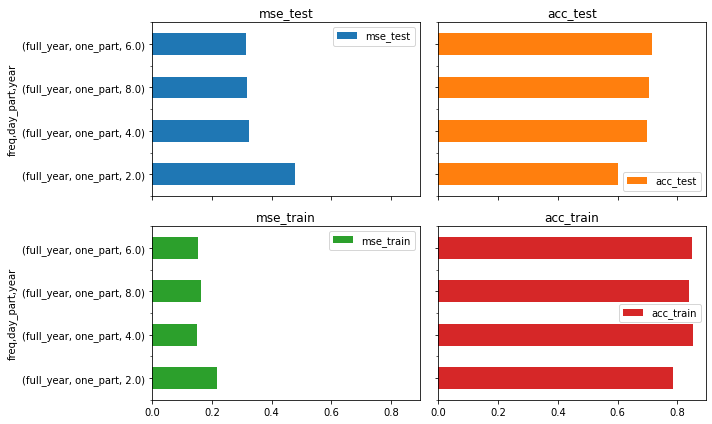

In [ ]:
df.groupby(['freq', 'day_part', 'year'])[['mse_test', 'acc_test', 'mse_train', 'acc_train']].mean()\
  .sort_values('mse_test', ascending=False)\
  .plot.barh(y=['mse_test', 'acc_test', 'mse_train', 'acc_train'], 
              subplots=True, layout=(2, 2), sharey=True, figsize=(10, 6))
plt.tight_layout()
plt.savefig('model_cmp.png')

# **CNN-LSTM Model**
## train on x **last** years predicted by HMM

In [ ]:
# train on full_day_part
"""data = {}

for year in range(2, 11, 2):

    for day_part in ['night', 'morning', 'noon', 'evening']:
        li = []
        for month in range(1, 13):
            filename = f'CP_{year}df_{month}_{day_part}_train.csv'
            dff = pd.read_csv(filename, index_col=None, header=0)
            li.append(dff)
        df_train = pd.concat(li, axis=0, ignore_index=True)
        df_train = df_train.sort_values(['year', 'month', 'week', 'day', 'night', 'morning', 'noon', 'evening'], ascending=[True]*4 + [False]*4).reset_index(drop=True)

        freq_part = 'full'
        model_name = '_'.join([freq_part, day_part])
        print(model_name)

        df_test = pd.read_csv(f'df_{model_name}_test.csv')

        REL_FEATURES_TRAIN = [' _dewptm_bars', ' _fog', ' _hail', ' _hum_bars', ' _pressurem_bars', ' _rain', ' _snow',
                ' _thunder', ' _tornado', ' _vism_bars', ' _wspdm_bars', 'night', 'morning',
                'noon', 'evening', 'month_cos', 'month_sin', 'week_cos', 'week_sin']
                
        REL_FEATURES_TEST = [ele for ele in REL_FEATURES if ele not in ['hour_sin', 'hour_cos']]

        mse_train, mse_test, acc_train, acc_test = main_func(df_train=df_train, df_test=df_test, timestep=7, 
                                                             rel_features_train=REL_FEATURES_TRAIN, 
                                                             rel_features_test=REL_FEATURES_TEST, 
                                                             epochs=200)
        data[f'{year}_{model_name}'] = [mse_train, mse_test, acc_train, acc_test]

df = pd.DataFrame.from_dict(data, orient='index', columns=['mse_train', 'mse_test', 'acc_train', 'acc_test'])
df.to_csv(r'results_hmm.csv', index = True)"""

full_night
MSE train: 0.36054420471191406
MSE test: 21.121294021606445
Accuracy train: 0.6557823129251701
Accuracy test: 0.12668463611859837
full_morning
MSE train: 0.17687074840068817
MSE test: 19.55769157409668
Accuracy train: 0.8394557823129252
Accuracy test: 0.038461538461538464
full_noon
MSE train: 0.5278911590576172
MSE test: 11.068681716918945
Accuracy train: 0.5482993197278911
Accuracy test: 0.06043956043956044
full_evening
MSE train: 0.4341192841529846
MSE test: 23.243698120117188
Accuracy train: 0.6213592233009708
Accuracy test: 0.06722689075630252
full_night
MSE train: 0.1818181872367859
MSE test: 17.458221435546875
Accuracy train: 0.8243335611756665
Accuracy test: 0.0862533692722372
full_morning
MSE train: 0.16814763844013214
MSE test: 15.917582511901855
Accuracy train: 0.8475734791524265
Accuracy test: 0.04120879120879121
full_noon
MSE train: 0.3362952768802643
MSE test: 15.505494117736816
Accuracy train: 0.6924128503075871
Accuracy test: 0.06043956043956044
full_evening
M

In [ ]:
# train on month_day_part
data = {}

for year in range(2, 11, 2):

    for day_part in ['night', 'morning', 'noon', 'evening']:
        for month in range(1, 13):
            filename = f'CP_{year}df_{month}_{day_part}_train.csv'
            df_train = pd.read_csv(filename, index_col=None, header=0)
            df_train = df_train.sort_values(['year', 'month', 'week', 'day', 'night', 'morning', 'noon', 'evening'], ascending=[True]*4 + [False]*4).reset_index(drop=True)

            model_name = '_'.join([str(month), day_part])
            print(model_name)

            df_test = pd.read_csv(f'df_{model_name}_test.csv')
            df_test = df_test.sort_values(['year', 'month', 'week', 'day', 'night', 'morning', 'noon', 'evening'], ascending=[True]*4 + [False]*4).reset_index(drop=True)

            REL_FEATURES_TRAIN = [' _dewptm_bars', ' _fog', ' _hail', ' _hum_bars', ' _pressurem_bars', ' _rain', ' _snow',
                    ' _thunder', ' _tornado', ' _vism_bars', ' _wspdm_bars', 'night', 'morning',
                    'noon', 'evening', 'month_cos', 'month_sin', 'week_cos', 'week_sin']
                    
            REL_FEATURES_TEST = [ele for ele in REL_FEATURES if ele not in ['hour_sin', 'hour_cos']]

            mse_train, mse_test, acc_train, acc_test = main_func(df_train=df_train, df_test=df_test, timestep=7, 
                                                                rel_features_train=REL_FEATURES_TRAIN, 
                                                                rel_features_test=REL_FEATURES_TEST, 
                                                                epochs=200)
            data[f'{year}_{model_name}'] = [mse_train, mse_test, acc_train, acc_test]

df = pd.DataFrame.from_dict(data, orient='index', columns=['mse_train', 'mse_test', 'acc_train', 'acc_test'])
df.to_csv(r'results_hmm.csv', index = True)

1_night
MSE train: 0.0
MSE test: 0.6857143044471741
Accuracy train: 1.0
Accuracy test: 0.5714285714285714
2_night
MSE train: 0.01587301678955555
MSE test: 3.942857027053833
Accuracy train: 0.9841269841269841
Accuracy test: 0.0
3_night
MSE train: 0.0317460335791111
MSE test: 10.199999809265137
Accuracy train: 0.9682539682539683
Accuracy test: 0.0
4_night
MSE train: 0.2063492089509964
MSE test: 32.94285583496094
Accuracy train: 0.8412698412698413
Accuracy test: 0.0
5_night
MSE train: 0.0634920671582222
MSE test: 29.02857208251953
Accuracy train: 0.9841269841269841
Accuracy test: 0.0
6_night
MSE train: 0.1111111119389534
MSE test: 43.771427154541016
Accuracy train: 0.8888888888888888
Accuracy test: 0.0
7_night
MSE train: 0.0
MSE test: 40.771427154541016
Accuracy train: 1.0
Accuracy test: 0.0
8_night
MSE train: 0.0476190485060215
MSE test: 34.71428680419922
Accuracy train: 0.9523809523809523
Accuracy test: 0.0
9_night
MSE train: 0.0317460335791111
MSE test: 25.342857360839844
Accuracy trai

In [ ]:
# train on season_day_part
"""data = {}

for year in range(2, 11, 2):

    for day_part in ['night', 'morning', 'noon', 'evening']:
        for season in ['winter', 'spring', 'summer', 'monsoon', 'autumn']:
            filename = f'CP_{year}df_{season}_{day_part}_train.csv'
            df_train = pd.read_csv(filename, index_col=None, header=0)
            df_train = df_train.sort_values(['year', 'month', 'week', 'day', 'night', 'morning', 'noon', 'evening'], ascending=[True]*4 + [False]*4).reset_index(drop=True)

            model_name = '_'.join([season, day_part])
            print(model_name)

            df_test = pd.read_csv(f'df_{model_name}_test.csv')
            df_test = df_test.sort_values(['year', 'month', 'week', 'day', 'night', 'morning', 'noon', 'evening'], ascending=[True]*4 + [False]*4).reset_index(drop=True)

            REL_FEATURES_TRAIN = [' _dewptm_bars', ' _fog', ' _hail', ' _hum_bars', ' _pressurem_bars', ' _rain', ' _snow',
                    ' _thunder', ' _tornado', ' _vism_bars', ' _wspdm_bars', 'night', 'morning',
                    'noon', 'evening', 'month_cos', 'month_sin', 'week_cos', 'week_sin']
                    
            REL_FEATURES_TEST = [ele for ele in REL_FEATURES if ele not in ['hour_sin', 'hour_cos']]

            mse_train, mse_test, acc_train, acc_test = main_func(df_train=df_train, df_test=df_test, timestep=7, 
                                                                rel_features_train=REL_FEATURES_TRAIN, 
                                                                rel_features_test=REL_FEATURES_TEST, 
                                                                epochs=500)
            data[f'{year}_{model_name}'] = [mse_train, mse_test, acc_train, acc_test]

df = pd.DataFrame.from_dict(data, orient='index', columns=['mse_train', 'mse_test', 'acc_train', 'acc_test'])
df.to_csv(r'results_hmm.csv', index = True)"""

winter_night
MSE train: 0.012422360479831696
MSE test: 0.6507936716079712
Accuracy train: 0.9875776397515528
Accuracy test: 0.5396825396825397
spring_night
MSE train: 0.0
MSE test: 5.603174686431885
Accuracy train: 1.0
Accuracy test: 0.20634920634920634
summer_night
MSE train: 0.5
MSE test: 24.775510787963867
Accuracy train: 0.5756302521008403
Accuracy test: 0.0
monsoon_night
MSE train: 0.06896551698446274
MSE test: 34.17856979370117
Accuracy train: 0.9310344827586207
Accuracy test: 0.0
autumn_night
MSE train: 0.09183673560619354
MSE test: 11.53246784210205
Accuracy train: 0.923469387755102
Accuracy test: 0.07792207792207792
winter_morning
MSE train: 0.006211180239915848
MSE test: 6.682539463043213
Accuracy train: 0.9937888198757764
Accuracy test: 0.2222222222222222
spring_morning
MSE train: 0.04968944191932678
MSE test: 16.079364776611328
Accuracy train: 0.968944099378882
Accuracy test: 0.0
summer_morning
MSE train: 0.3193277418613434
MSE test: 30.36263656616211
Accuracy train: 0.7058

In [ ]:
# train on full_day_part concatanate by season
data = {}

for year in range(2, 11, 2):

    for day_part in ['night', 'morning', 'noon', 'evening']:
        li = []
        for season in ['winter', 'spring', 'summer', 'monsoon', 'autumn']:
            filename = f'CP_{year}df_{season}_{day_part}_train.csv'
            dff = pd.read_csv(filename, index_col=None, header=0)
            li.append(dff)
        df_train = pd.concat(li, axis=0, ignore_index=True)
        df_train = df_train.sort_values(['year', 'month', 'week', 'day', 'night', 'morning', 'noon', 'evening'], ascending=[True]*4 + [False]*4).reset_index(drop=True)

        freq_part = 'full'
        model_name = '_'.join([freq_part, day_part])
        print(model_name)

        df_test = pd.read_csv(f'df_{model_name}_test.csv')

        REL_FEATURES_TRAIN = [' _dewptm_bars', ' _fog', ' _hail', ' _hum_bars', ' _pressurem_bars', ' _rain', ' _snow',
                ' _thunder', ' _tornado', ' _vism_bars', ' _wspdm_bars', 'night', 'morning',
                'noon', 'evening', 'month_cos', 'month_sin', 'week_cos', 'week_sin']
                
        REL_FEATURES_TEST = [ele for ele in REL_FEATURES if ele not in ['hour_sin', 'hour_cos']]

        mse_train, mse_test, acc_train, acc_test = main_func(df_train=df_train, df_test=df_test, timestep=7, 
                                                             rel_features_train=REL_FEATURES_TRAIN, 
                                                             rel_features_test=REL_FEATURES_TEST, 
                                                             epochs=200)
        data[f'{year}_{model_name}'] = [mse_train, mse_test, acc_train, acc_test]

df = pd.DataFrame.from_dict(data, orient='index', columns=['mse_train', 'mse_test', 'acc_train', 'acc_test'])
df.to_csv(r'results_hmm.csv', index = True)

full_night
MSE train: 0.4306878447532654
MSE test: 15.064689636230469
Accuracy train: 0.671957671957672
Accuracy test: 0.05390835579514825
full_morning
MSE train: 0.17248676717281342
MSE test: 30.08791160583496
Accuracy train: 0.8433862433862434
Accuracy test: 0.024725274725274724
full_noon
MSE train: 0.20317460596561432
MSE test: 24.096153259277344
Accuracy train: 0.8126984126984127
Accuracy test: 0.06868131868131869
full_evening
MSE train: 0.5134264230728149
MSE test: 23.369747161865234
Accuracy train: 0.5596133190118152
Accuracy test: 0.025210084033613446
full_night
MSE train: 0.290493905544281
MSE test: 13.436657905578613
Accuracy train: 0.7472118959107806
Accuracy test: 0.09973045822102426
full_morning
MSE train: 0.23313860595226288
MSE test: 8.942307472229004
Accuracy train: 0.7843866171003717
Accuracy test: 0.09340659340659341
full_noon
MSE train: 0.2766861319541931
MSE test: 5.0521979331970215
Accuracy train: 0.7652681890600106
Accuracy test: 0.12362637362637363
full_evening
MS

In [ ]:
df

,mse_train,mse_test,acc_train,acc_test
2_full_night,0.430688,15.064690,0.671958,0.053908
2_full_morning,0.172487,30.087912,0.843386,0.024725
2_full_noon,0.203175,24.096153,0.812698,0.068681
2_full_evening,0.513426,23.369747,0.559613,0.025210
4_full_night,0.290494,13.436658,0.747212,0.099730
4_full_morning,0.233139,8.942307,0.784387,0.093407
4_full_noon,0.276686,5.052198,0.765268,0.123626
4_full_evening,0.233620,18.865545,0.786788,0.022409
6_full_night,0.183876,9.067386,0.833451,0.153639
6_full_morning,0.298476,14.417583,0.731655,0.063187


## Analyze results

In [ ]:

#df = pd.read_csv(r'res/results.csv', index_col=0)
# df['freq'] = ''
# df['day_part'] = ''

for model_name, model_row in df.iterrows():
#     print('\t', (model_name))

    if 'full' in str(model_name):
#         print('full_year')
        df.loc[model_name, 'freq'] = 'full_year'
    elif any(season in str(model_name) for season in ['winter', 'spring', 'summer', 'monsoon', 'autumn']):
#         print('season')
        df.loc[model_name, 'freq'] = 'season'
    elif any(str(month) in str(model_name) for month in range(1,13)):
#         print('month')
        df.loc[model_name, 'freq'] = 'month'
    else:
        raise 'error'
    if 'all' in str(model_name):
#         print('all_day')
        df.loc[model_name, 'day_part'] = 'all_day'
    elif any(season in str(model_name) for season in ['night', 'morning', 'noon', 'evening']):
#         print('day_part')
        df.loc[model_name, 'day_part'] = 'one_part'
    else:
        raise 'error'
    for year in range(2, 11, 2):
        if str(year) in str(model_name):
            df.loc[model_name, 'year'] = year

df

,mse_train,mse_test,acc_train,acc_test,freq,day_part,year
2_1_night,0.000000,0.685714,1.000000,0.571429,month,one_part,2.0
2_2_night,0.015873,3.942857,0.984127,0.000000,month,one_part,2.0
2_3_night,0.031746,10.200000,0.968254,0.000000,month,one_part,2.0
2_4_night,0.206349,32.942856,0.841270,0.000000,month,one_part,4.0
2_5_night,0.063492,29.028572,0.984127,0.000000,month,one_part,2.0
...,...,...,...,...,...,...,...
10_8_evening,0.240418,35.714287,0.780488,0.000000,month,one_part,10.0
10_9_evening,0.328904,26.685715,0.700997,0.000000,month,one_part,10.0
10_10_evening,0.259740,20.685715,0.769481,0.000000,month,one_part,10.0
10_11_evening,0.295681,7.371428,0.774086,0.000000,month,one_part,10.0


In [ ]:
df.groupby(['freq', 'day_part', 'year'])[['mse_test', 'acc_test', 'mse_train', 'acc_train']].mean()

mse_test  acc_test  mse_train  acc_train
freq  day_part year                                           
month one_part 2.0   22.087277  0.083036   0.065476   0.946925
               4.0   26.496965  0.047857   0.178844   0.845759
               6.0   28.886309  0.063690   0.235587   0.802325
               8.0   27.684822  0.050000   0.442805   0.658545
               10.0  24.060938  0.034821   0.246891   0.789619

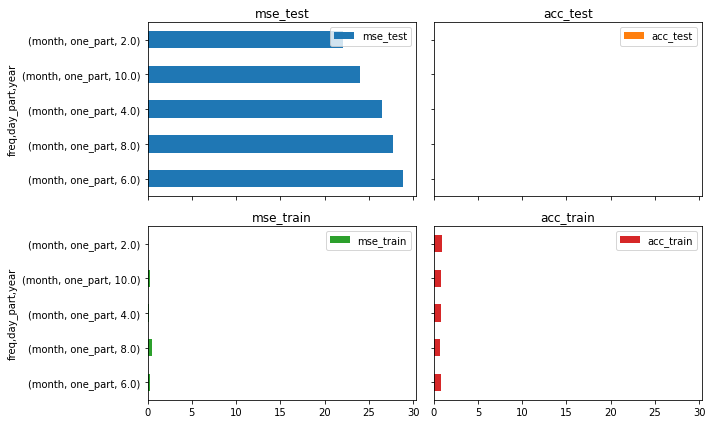

In [ ]:
df.groupby(['freq', 'day_part', 'year'])[['mse_test', 'acc_test', 'mse_train', 'acc_train']].mean()\
  .sort_values('mse_test', ascending=False)\
  .plot.barh(y=['mse_test', 'acc_test', 'mse_train', 'acc_train'], 
              subplots=True, layout=(2, 2), sharey=True, figsize=(10, 6))
plt.tight_layout()
plt.savefig('model_cmp.png')